# Kernel Based Discrepancies

Author: Jimmy Nguyen (nguyen.hoang.jimmy42@gmail.com)

This notebook walks through kernel based discrepancies using the Kronecker sequence.

One definition of discrepancy starts with a symmetric, positive definite kernel, $K:[0,1]^d\times [0,1]^d \to \mathbb{R}$, i.e.,
\begin{gather*}
K(\boldsymbol{t},\boldsymbol{x}) = K(\boldsymbol{x},\boldsymbol{t}) \qquad \forall \boldsymbol{t}, \boldsymbol{x} \in [0,1]^d \\
\sum_{i,j = 1}^{n} c_i K(\boldsymbol{x}_i,\boldsymbol{x}_j ) \boldsymbol{c}_j > 0 \qquad \forall \boldsymbol{c} \ne \boldsymbol{0}, \ \boldsymbol{x}_1, \ldots, \boldsymbol{x}_n \text{ distinct and } \in [0,1]^d
\end{gather*}
The discrepancy, $D(\{\boldsymbol{x}\}_{i=1}^n)$ is defined in terms of the kernel as
$$
[D(\{\boldsymbol{x}_i\}_{i=1}^n,K)]^2= \int_{[0,1]^d} \int_{[0,1]^d} K(\boldsymbol{t},\boldsymbol{x}) \, \mathrm{d}\boldsymbol{t} \mathrm{d}\boldsymbol{x}
- \frac{2}{n} \sum_{i=1}^n \int_{[0,1]^d} K(\boldsymbol{t}, \boldsymbol{x}_i) \, \mathrm{d}\boldsymbol{t}
+ \frac{1}{n^2} \sum_{i,j = 1}^n K(\boldsymbol{x}_i, \boldsymbol{x}_j)
$$
The discrepancy requires $\mathcal{O}(dn^2)$ operations to compute, assuming one evaluation of the kernel requires $d$ operations to compute.

We can simplify the cost to compute the discrepancy for a randomly shifted Kronecker sequence:
$$
\begin{aligned}
\text{Kronecker: } \mathbb{E}\{[D(\{i\boldsymbol{\alpha} + \boldsymbol{\Delta} \bmod \boldsymbol{1}\}_{i=1}^n,K)]^2\}
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} + \frac{1}{n^2} \sum_{i,j = 1}^n \int_{[0,1]^d} \widetilde{K}((i - j)\boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& =  - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t} 
+ \frac 1{n^2} \sum_{k=1-n}^{n-1}  (n -  \lvert k \rvert)\widetilde{K}(k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
& = - \int_{[0,1]^d} \widetilde{K}(\boldsymbol{t}) \, \mathrm{d}\boldsymbol{t}
+ \frac 1{n^2} \biggl[n \widetilde{K}(\boldsymbol{0}) +  2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \biggr] \\
\end{aligned}
$$

$$
2\sum_{k=1}^{n-1}  (n - k)\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) \\
= 2\left(n\sum_{k=1}^{n-1} \widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1}) - \sum_{k=1}^{n-1} k\widetilde{K} (k \boldsymbol{\alpha} \bmod \boldsymbol{1})\right)
$$

After splitting the above summation, we can compute the discrepancy values for n = 1,2,...,N in $\mathcal{O}(dN)$ time.
The code can be found at qmcpy/discrete_distribution/kronecker.py.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qmcpy as qp

In [2]:
def plot_discrepancy(dimension, alpha, n=1e6, gamma=None, trend=True, title=None):
    kronecker = qp.Kronecker(dimension=dimension, alpha=alpha)

    if gamma is None:
        values = kronecker.periodic_discrepancy(int(n))
    else:
        values = kronecker.periodic_discrepancy(int(n), gamma=gamma)

    x = np.arange(1, int(n) + 1)
    y = values[0] / x # multiply by values[0] to get the same starting point
    y_half = values[0] / np.sqrt(x)
    if trend:
        plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
        plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')

    plt.loglog(x, values, label="Kronecker")
    
    if title is not None:
        plt.title(title)
        
    plt.xlabel('Number of sample points')
    plt.ylabel('Discrepancy')
    plt.legend()
    plt.show()

# Example with a Specified $\widetilde{K}$

Take $\widetilde{K}(x) = \prod_{\ell = 1}^d \left [1 + \gamma_\ell B_2(x_\ell) \right] = \prod_{\ell = 1}^d \left [1 + \gamma_\ell \left \{x_\ell(x_\ell - 1) + \frac 16 \right\}\right] $ with $d=2$ and $\gamma_\ell = 1$.

This is an example of the discrepancy when alpha is the Richtmyer sequence.

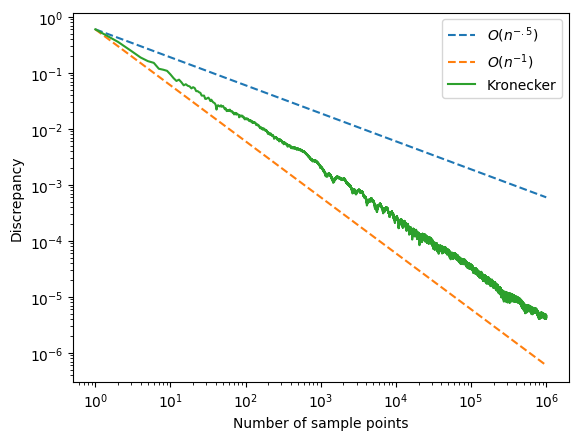

In [3]:
plot_discrepancy(2, 'richtmyer')

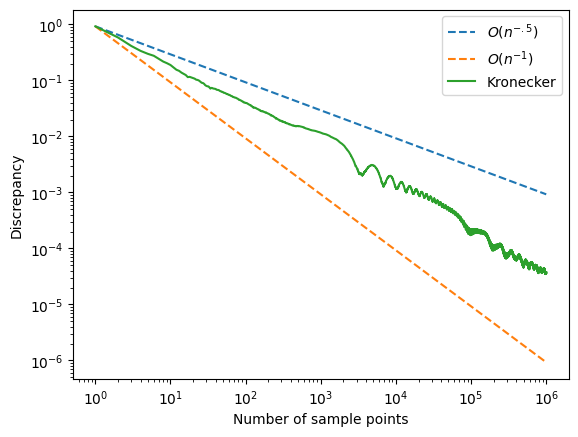

In [4]:
plot_discrepancy(4, 'richtmyer')

We can select good choices of alpha using alpha_generate() from Kronecker.ipynb. Coordinate weights 1/$\ell^2$ were used in the search.
Since we use a component by component search, we can use the first s alphas and they should be good alphas for s dimensions.

In [5]:
alpha = np.array([0.41970205, 0.30515781, 0.36519739, 0.22938431, 0.44863466, 0.28152844, 0.37796908, 0.17803384, 0.21661381, 0.23889719, 0.23588547, 0.26587686, 0.18453324, 0.35177543, 0.46455079, 0.12079046, 0.43843606, 0.14882175, 0.4532197, 0.17177015])

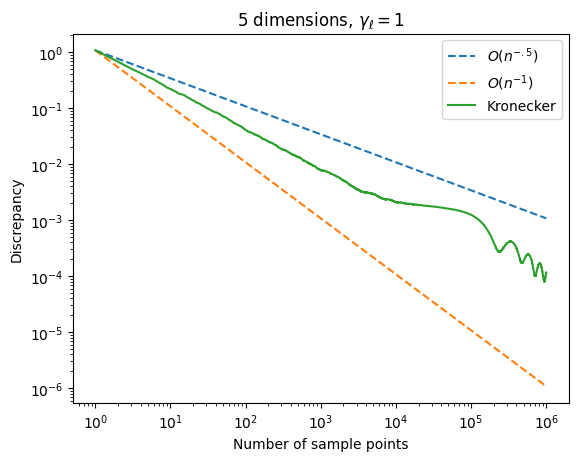

In [6]:
plot_discrepancy(dimension=5, alpha=alpha[:5], title='5 dimensions, $\\gamma_\\ell = 1$')

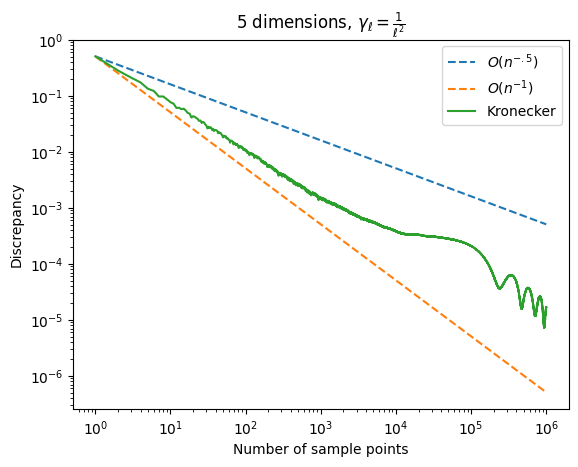

In [7]:
plot_discrepancy(dimension=5,
                 alpha=alpha[:5],
                 gamma = 1 / np.arange(1, 5 + 1) ** 2,
                 title='5 dimensions, $\\gamma_\\ell = \\frac{1}{\\ell^2}$')

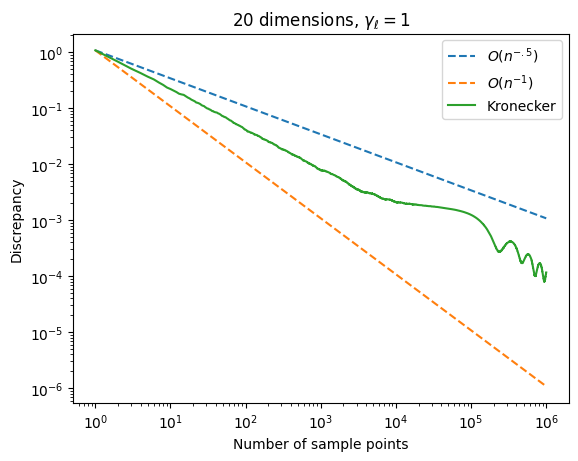

In [8]:
plot_discrepancy(dimension=5, alpha=alpha[:5], title='20 dimensions, $\\gamma_\\ell = 1$')

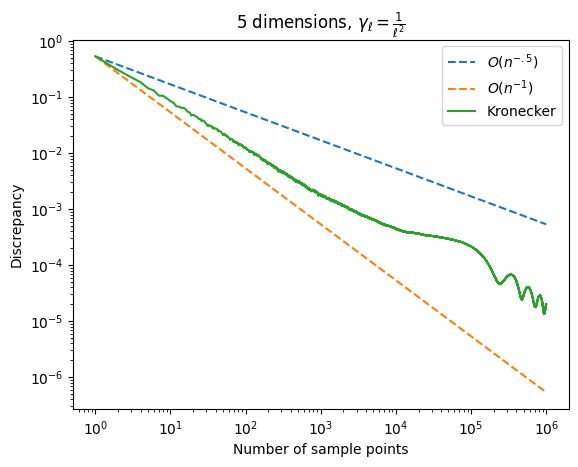

In [9]:
plot_discrepancy(20, alpha=alpha, gamma = 1 / np.arange(1, 20 + 1) ** 2, title = '5 dimensions, $\\gamma_\\ell = \\frac{1}{\\ell^2}$')

Some examples with random alphas:

[0.5488135  0.71518937]


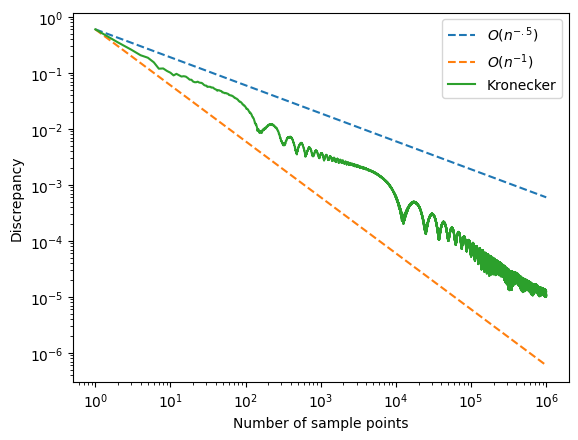

[0.417022   0.72032449]


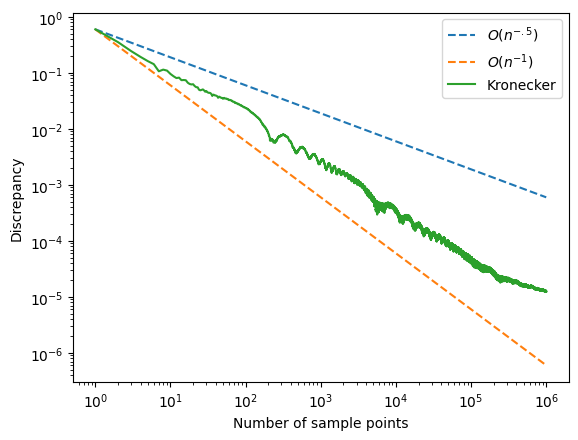

[0.4359949  0.02592623]


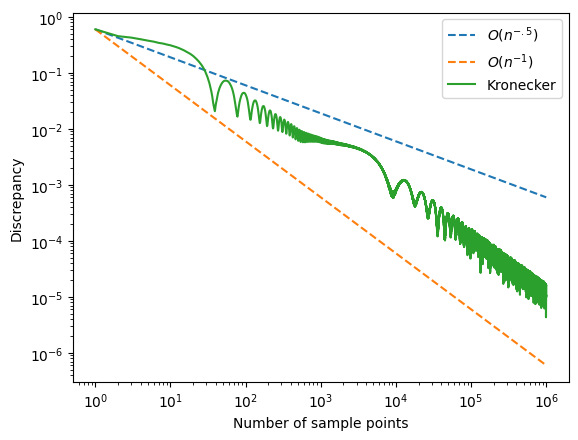

[0.5507979  0.70814782]


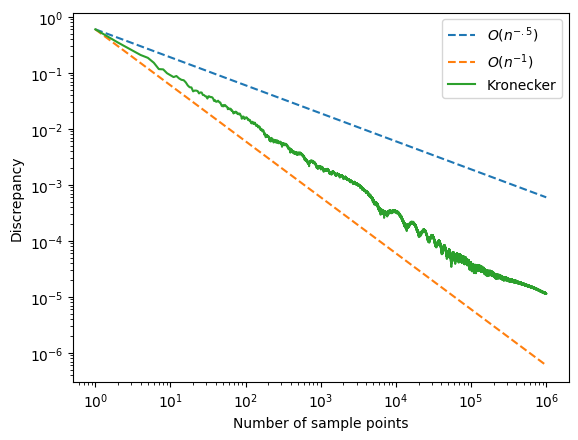

[0.96702984 0.54723225]


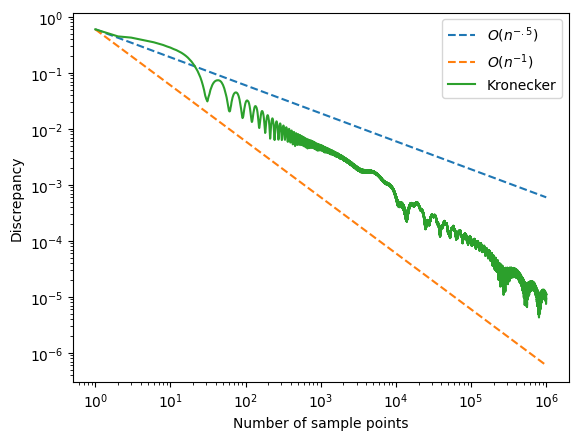

[0.22199317 0.87073231]


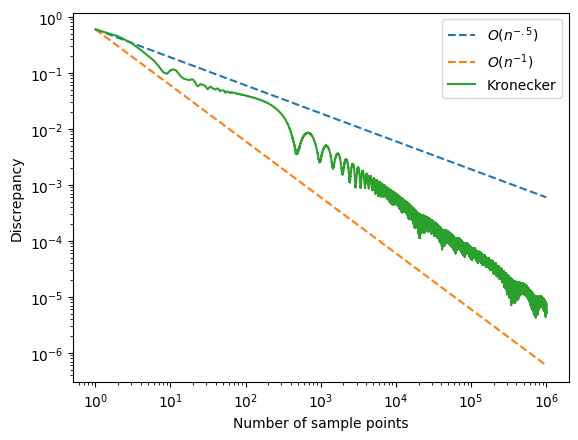

[0.89286015 0.33197981]


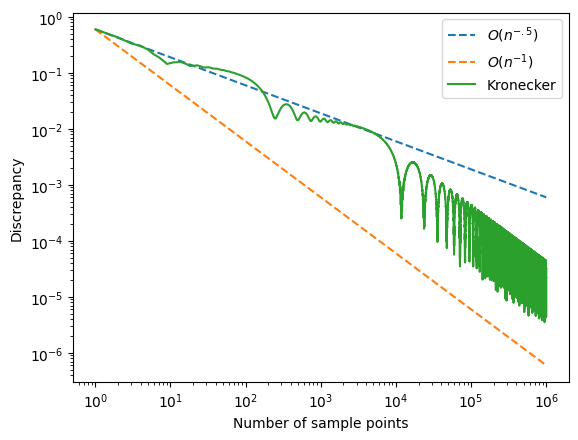

[0.07630829 0.77991879]


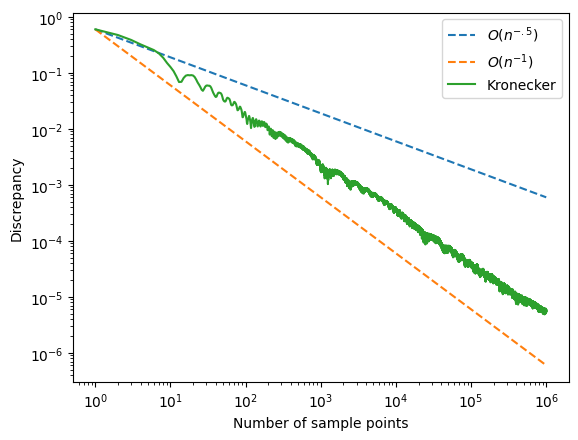

In [10]:
for i in range(8):
    np.random.seed(i)
    random = np.random.rand(2)
    print(random)
    kronecker = qp.Kronecker(dimension=2, alpha=random)
    values = kronecker.periodic_discrepancy(int(1e6))
    
    x = np.arange(1, int(1e6) + 1)
    y = values[0] / x # multiply by values[0] to get the same starting point
    y_half = values[0] / np.sqrt(x)

    plt.loglog(x, y_half, label = '$O(n^{-.5})$', linestyle = '--')
    plt.loglog(x, y, label = '$O(n^{-1})$', linestyle = '--')
    plt.loglog(x, values, label="Kronecker")

    plt.xlabel('Number of sample points')
    plt.ylabel('Discrepancy')
    plt.legend()
    plt.show()

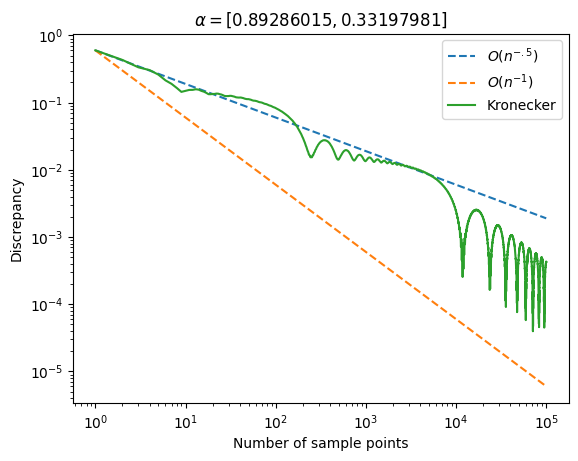

In [12]:
plot_discrepancy(2, alpha = [0.89286015, 0.33197981], n=1e5, title = '$\\alpha=[0.89286015, 0.33197981]$')